In [405]:
import tabula
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import statistics
import numpy as np
import math
from scipy import stats
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.cluster import KMeans
import geopandas as gpd

In [155]:
processed_waste_df = pd.read_csv("processed_waste_dataset.csv")
population_df = pd.read_excel("austion_population_growth.xlsx")
# Filter population_df from 2006 (before 2006 garbage data is imcpmplete or unexistant) to 2016 (max)
population_df = population_df[(population_df['Year'] >= 2006)]


In [156]:
# Sum weigth per year
processed_waste_df[['Year','Month', 'Day']] = processed_waste_df['time'].str.split('-', expand=True)
processed_waste_df = processed_waste_df[(processed_waste_df['Year'] >= "2006")]
processed_waste_df['Day'] = processed_waste_df["Day"].astype(int)
processed_waste_df['Year'] = processed_waste_df["Year"].astype(int)
processed_waste_df['Month'] = processed_waste_df["Month"].astype(int)
population_df['Year'] = population_df["Year"].astype(int)

processed_waste_df

,time,weight,Year,Month,Day
354,2006-01-02,1200980.0,2006,1,2
355,2006-01-03,1103200.0,2006,1,3
356,2006-01-04,1156800.0,2006,1,4
357,2006-01-05,1062760.0,2006,1,5
358,2006-01-06,996180.0,2006,1,6
...,...,...,...,...,...
5098,2021-07-06,1096040.0,2021,7,6
5099,2021-07-07,879290.0,2021,7,7
5100,2021-07-08,821640.0,2021,7,8
5101,2021-07-09,23060.0,2021,7,9


In [92]:
waste_by_year = processed_waste_df.groupby(['Year']).agg({'weight':'sum', 'Day': 'count',}).reset_index()
waste_by_year.rename(columns={"weight": "total_weight", "Day": "Total_Days"}, inplace=True)
waste_by_year["Weight_by_Day"] = waste_by_year["total_weight"] / waste_by_year["Total_Days"]
waste_by_year

,Year,total_weight,Total_Days,Weight_by_Day
0,2006,2.658563e+08,302,880318.870861
1,2007,2.841013e+08,301,943858.259136
2,2008,2.798706e+08,299,936022.150502
3,2009,2.559121e+08,308,830883.564935
4,2010,2.596277e+08,307,845692.833876
5,2011,2.486790e+08,310,802190.451613
6,2012,2.556717e+08,309,827416.601942
7,2013,2.508294e+08,308,814381.123377
8,2014,2.583303e+08,309,836020.430421
9,2015,2.641038e+08,297,889238.484848


In [108]:
# join both dataframes
_waste_population_df = waste_by_year.merge(population_df, how = 'left', left_on = 'Year', right_on = 'Year')
_waste_population_df = _waste_population_df[['Year','total_weight','Weight_by_Day','City_of_Austin_Total_Area_Population']]
_waste_population_df = _waste_population_df.dropna()
_waste_population_df

,Year,total_weight,Weight_by_Day,City_of_Austin_Total_Area_Population
0,2006,265856299.0,880318.870861,718.912
1,2007,284101336.0,943858.259136,735.088
2,2008,279870623.0,936022.150502,750.525
3,2009,255912138.0,830883.564935,774.037
4,2010,259627700.0,845692.833876,790.390
5,2011,248679040.0,802190.451613,812.025
6,2012,255671730.0,827416.601942,832.326
7,2013,250829386.0,814381.123377,855.215
8,2014,258330313.0,836020.430421,878.733
9,2015,264103830.0,889238.484848,900.701


<AxesSubplot:xlabel='Year'>

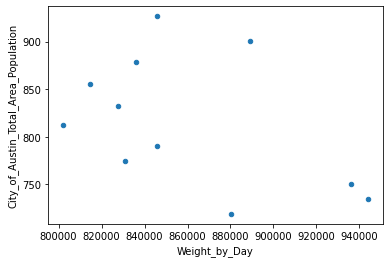

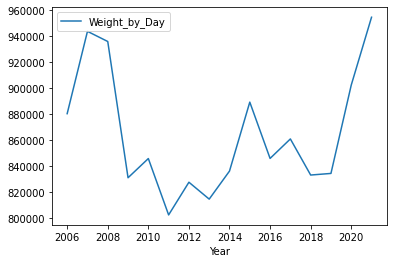

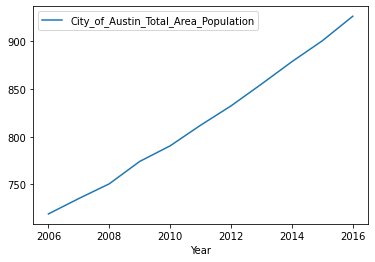

In [112]:
_waste_population_df.plot(x ='Weight_by_Day', y='City_of_Austin_Total_Area_Population', kind = 'scatter')
waste_by_year.plot(x ='Year', y='Weight_by_Day', kind = 'line')
_waste_population_df.plot(x ='Year', y='City_of_Austin_Total_Area_Population', kind = 'line')

Although population increased, it appears to have no relation with waste collected per day. Besides, this value shows inconstant variations along the year (no detectable trend through the years, except for the rapid increase since 2019)

## Number of loads vs Weight collected

Is the number of loads related with the total weight? (i.e. is Austin doing many loads in areas that produce little waste?)

In [581]:
loads_df = pd.read_csv("waste_collection.csv").iloc[:, 1:]
loads_df['Load Weight'] = loads_df['Load Weight'].astype(float)
loads_df

,Load Type,Load Time,Load Weight,Dropoff Site,Route Type,Route Number,Load ID,Load Date
0,RECYCLING - PAPER,2000-01-26 12:39:00,2940.0,MRF,RECYCLING,RH12,163262,2000-01-26 00:00:00
1,BULK,2001-03-16 09:38:00,4240.0,TDS LANDFILL,BULK,BU05,522335,2001-03-16 00:00:00
2,BULK,2001-03-16 13:33:00,4740.0,TDS LANDFILL,BULK,BU05,522334,2001-03-16 00:00:00
3,BULK,2001-10-16 11:51:00,14080.0,TDS LANDFILL,BULK,BU16,545997,2001-10-16 00:00:00
4,BULK,2001-10-16 15:28:00,8260.0,TDS LANDFILL,BULK,BU16,545996,2001-10-16 00:00:00
...,...,...,...,...,...,...,...,...
655357,BULK,2021-07-11 07:07:01,10100.0,TDS LANDFILL,BULK,BU27,842414,2021-07-11 00:00:00
655358,TIRES,2021-07-11 07:07:05,1500.0,TDS LANDFILL,BULK,BU16,848381,2021-07-11 00:00:00
655359,TIRES,2021-07-11 07:07:05,2120.0,MRF,BULK,BU16,848380,2021-07-11 00:00:00
655360,GARBAGE COLLECTIONS,2021-07-11 07:07:42,17200.0,TDS LANDFILL,GARBAGE COLLECTION,PW30,928229,2021-07-11 00:00:00


In [583]:
loads_df[['Date','Time']] = loads_df['Load Time'].str.split(' ', expand=True)
loads_df[['Year','Month', 'Day']] = loads_df['Date'].str.split('-', expand=True)
loads_df['Year'] = loads_df['Year'].astype(int)
loads_df

,Load Type,Load Time,Load Weight,Dropoff Site,Route Type,Route Number,Load ID,Load Date,Date,Time,Year,Month,Day
0,RECYCLING - PAPER,2000-01-26 12:39:00,2940.0,MRF,RECYCLING,RH12,163262,2000-01-26 00:00:00,2000-01-26,12:39:00,2000,01,26
1,BULK,2001-03-16 09:38:00,4240.0,TDS LANDFILL,BULK,BU05,522335,2001-03-16 00:00:00,2001-03-16,09:38:00,2001,03,16
2,BULK,2001-03-16 13:33:00,4740.0,TDS LANDFILL,BULK,BU05,522334,2001-03-16 00:00:00,2001-03-16,13:33:00,2001,03,16
3,BULK,2001-10-16 11:51:00,14080.0,TDS LANDFILL,BULK,BU16,545997,2001-10-16 00:00:00,2001-10-16,11:51:00,2001,10,16
4,BULK,2001-10-16 15:28:00,8260.0,TDS LANDFILL,BULK,BU16,545996,2001-10-16 00:00:00,2001-10-16,15:28:00,2001,10,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
655357,BULK,2021-07-11 07:07:01,10100.0,TDS LANDFILL,BULK,BU27,842414,2021-07-11 00:00:00,2021-07-11,07:07:01,2021,07,11
655358,TIRES,2021-07-11 07:07:05,1500.0,TDS LANDFILL,BULK,BU16,848381,2021-07-11 00:00:00,2021-07-11,07:07:05,2021,07,11
655359,TIRES,2021-07-11 07:07:05,2120.0,MRF,BULK,BU16,848380,2021-07-11 00:00:00,2021-07-11,07:07:05,2021,07,11
655360,GARBAGE COLLECTIONS,2021-07-11 07:07:42,17200.0,TDS LANDFILL,GARBAGE COLLECTION,PW30,928229,2021-07-11 00:00:00,2021-07-11,07:07:42,2021,07,11


In [584]:
loads_df[(loads_df['Year'] >= 2010)]['Load Weight'].sum()

5591158273.5394

In [207]:
loads_by_year = loads_df.copy()
loads_by_year = loads_by_year.groupby(['Year']).agg({'Load Weight':'sum', 'Load ID': 'count'}).reset_index()
loads_by_year.rename(columns={"Load Weight": "Total_Weight", "Load ID": "Total_Loads"}, inplace=True)
loads_by_year = loads_by_year[(loads_by_year['Year'] >= 2005)]
loads_by_year['Weight_by_Load'] = loads_by_year["Total_Weight"] / loads_by_year["Total_Loads"]
loads_by_year

,Year,Total_Weight,Total_Loads,Weight_by_Load
1,2005,2.556074e+08,16010,15965.483573
2,2006,2.658563e+08,17088,15558.069932
3,2007,2.840972e+08,17772,15985.661490
4,2008,2.798706e+08,17906,15629.991232
5,2009,2.559121e+08,14882,17196.085069
6,2010,2.596277e+08,14680,17685.810627
7,2011,2.486689e+08,14217,17490.953084
8,2012,2.556717e+08,14377,17783.385268
9,2013,2.508294e+08,14238,17616.897458
10,2014,2.583042e+08,14664,17614.853587


<AxesSubplot:xlabel='Year'>

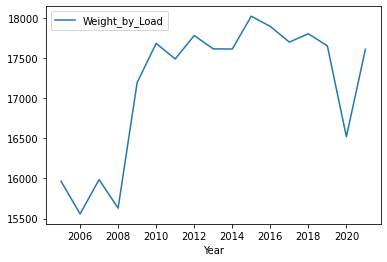

In [208]:
loads_by_year.plot(x ='Year', y='Weight_by_Load', kind = 'line')

2020 menos peso msm numero de rotas. No futuro pode-se pensar nisto

<AxesSubplot:xlabel='Year'>

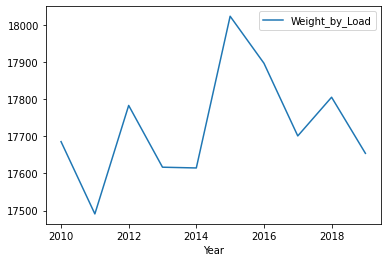

In [212]:
loads_by_year = loads_by_year[(loads_by_year['Year'] >= 2010) & (loads_by_year['Year'] < 2020)]
loads_by_year.plot(x ='Year', y='Weight_by_Load', kind = 'line')

In [213]:
loads_by_yearroute = loads_df.copy()
loads_by_yearroute = loads_by_yearroute[(loads_by_yearroute['Year'] >= 2010)]
loads_by_yearroute = loads_by_yearroute.groupby(['Year','Route Number']).agg({'Load Weight':'sum', 'Load ID': 'count'}).reset_index()
loads_by_yearroute.rename(columns={"Load Weight": "Total_Weight", "Load ID": "Total_Loads"}, inplace=True)
loads_by_yearroute['Weight_by_Load'] = loads_by_yearroute['Total_Weight'] / loads_by_yearroute['Total_Loads']
loads_by_route_pivot = loads_by_yearroute.pivot(index='Route Number', columns='Year', values='Weight_by_Load')

#remove routes that are not done every year
loads_by_route_dropna = loads_by_route_pivot.dropna()

#A lot of routes have been started and left of through the years, so the best is to analysi by year
print(len(loads_by_route_pivot) - len(loads_by_route_dropna))
loads_by_route_pivot


200


Year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Route Number,,,,,,,,,,,,
BR25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8600.0
DA01,NaN,NaN,NaN,NaN,NaN,160.0,NaN,NaN,NaN,NaN,NaN,NaN
DF3,NaN,NaN,NaN,NaN,NaN,NaN,6760.0,NaN,NaN,NaN,NaN,NaN
DF4,NaN,NaN,NaN,NaN,NaN,NaN,7920.0,NaN,NaN,NaN,NaN,NaN
DH2,NaN,NaN,1100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
YH06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10340.0,NaN,NaN
YM04,NaN,2880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YM11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5880.0,NaN,NaN


Routes:292
Max Loads:108
Min Loads:1


<AxesSubplot:xlabel='Total_Loads', ylabel='Total_Weight'>

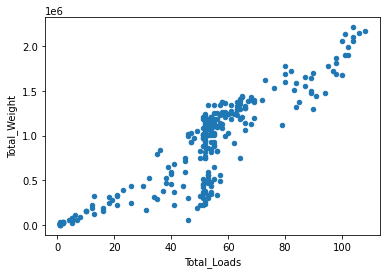

In [548]:
loads_by_route = loads_df.copy()
loads_by_route = loads_by_route[(loads_by_route['Year'] == 2019)]
loads_by_route = loads_by_route.groupby(['Route Number']).agg({'Load Weight':'sum', 'Load ID': 'count'}).reset_index()
loads_by_route.rename(columns={"Load Weight": "Total_Weight", "Load ID": "Total_Loads"}, inplace=True)
print(f'Routes:{len(loads_by_route)}')
print(f"Max Loads:{loads_by_route['Total_Loads'].max()}")
print(f"Min Loads:{loads_by_route['Total_Loads'].min()}")

loads_by_route.plot(x ='Total_Loads', y='Total_Weight', kind = 'scatter')


<AxesSubplot:xlabel='Route Number', ylabel='Weight_By_Load'>

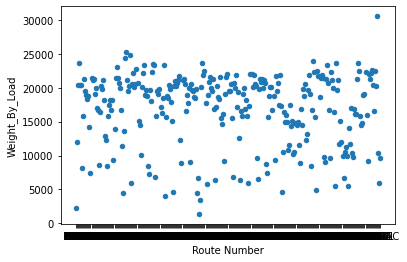

In [549]:
loads_by_route['Weight_By_Load'] = loads_by_route['Total_Weight'] / loads_by_route['Total_Loads']
loads_by_route.plot(x ='Route Number', y='Weight_By_Load', kind = 'scatter')

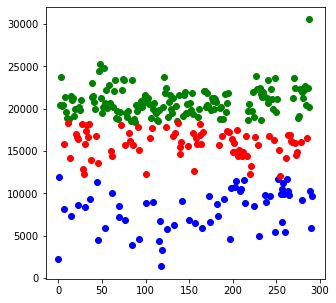

In [565]:
df_tofit = loads_by_route.copy()
df_tofit = df_tofit[['Weight_By_Load']]
# Using a basic KMeans algorithm
kmeans = KMeans(n_clusters=3, max_iter=500)

# Attempt 1: Just give it all the data in its raw, naked glory and see what it comes up with
kmeans.fit(df_tofit)

# Taking a look at what records were assigned to what cluster, I notice a disturbing trend: Salary is outweighing all other features
survey_df_c1 = df_tofit.copy()
survey_df_c1.insert(0, 'CLUSTER_LABEL', kmeans.labels_)
survey_df_c1[['Route Number','Total_Loads', 'Total_Weight']] = loads_by_route[['Route Number','Total_Loads', 'Total_Weight']]
survey_df_grouped = survey_df_c1.copy()
survey_df_grouped = survey_df_grouped.groupby('CLUSTER_LABEL').count()
# To prove that out a bit more I group by the cluster label and run some stats
cl1_groups = survey_df_c1.groupby(['CLUSTER_LABEL'])
df = cl1_groups.agg([np.mean])
fig, axs = plt.subplots(1, figsize=(5,5), sharex=True)
# individual chart chart
survey_df_c1 = survey_df_c1.reset_index()
axs.scatter(survey_df_c1[survey_df_c1['CLUSTER_LABEL']==0]['index'],survey_df_c1[survey_df_c1['CLUSTER_LABEL']==0]['Weight_By_Load'], color='green')
axs.scatter(survey_df_c1[survey_df_c1['CLUSTER_LABEL']==1]['index'],survey_df_c1[survey_df_c1['CLUSTER_LABEL']==1]['Weight_By_Load'], color='blue')
axs.scatter(survey_df_c1[survey_df_c1['CLUSTER_LABEL']==2]['index'],survey_df_c1[survey_df_c1['CLUSTER_LABEL']==2]['Weight_By_Load'], color='red')
axs.scatter(survey_df_c1[survey_df_c1['CLUSTER_LABEL']==3]['index'],survey_df_c1[survey_df_c1['CLUSTER_LABEL']==3]['Weight_By_Load'], color='black')

clustered_routes = survey_df_c1.copy()

In [566]:
garbage_boundaries = gpd.read_file('garbage_routes.geojson')
garbage_boundaries


,rt_old,garb_day,landfill,garb_rt,super_num,op_type,garb_sup,geometry
0,None,Thursday,TDS,PAH83,697,Auto,Gilbert,"MULTIPOLYGON (((-97.70618 30.36742, -97.70723 ..."
1,PAM84,Monday,TDS,PAM54,500,Auto,Castillo,"MULTIPOLYGON (((-97.83237 30.16213, -97.83237 ..."
2,None,Monday,TDS,PAM71,596,Auto,Carnline,"MULTIPOLYGON (((-97.72977 30.19009, -97.72103 ..."
3,PAH75,Thursday,TDS,PAH54,500,Auto,Castillo,"MULTIPOLYGON (((-97.65374 30.26269, -97.65322 ..."
4,None,Wednesday,TDS,PAW71,596,Auto,Carnline,"MULTIPOLYGON (((-97.64683 30.38640, -97.64724 ..."
...,...,...,...,...,...,...,...,...
179,None,Wednesday,TDS,PAW63,170,Auto,Litson,"MULTIPOLYGON (((-97.77238 30.42130, -97.77238 ..."
180,None,Monday,TDS,PAM72,596,Auto,Carnline,"MULTIPOLYGON (((-97.77343 30.14455, -97.77252 ..."
181,NO ROUTE,Monday,TDS,PAM73,596,Auto,Carnline,"MULTIPOLYGON (((-97.77932 30.15112, -97.77839 ..."
182,PAT71,Tuesday,TDS,PAT84,697,Auto,Gilbert,"MULTIPOLYGON (((-97.79986 30.24749, -97.79170 ..."


In [567]:
garbage_boundaries = gpd.read_file('garbage_routes.geojson')
garbage_boundaries = garbage_boundaries.drop_duplicates(subset = ['garb_rt', 'rt_old'])
route_numbers = list(garbage_boundaries['garb_rt'])
route_numbers =route_numbers + list(garbage_boundaries['rt_old'])
route_numbers = list(set(route_numbers))
route_numbers.remove('NO ROUTE')
route_numbers.remove(None)
garbage_boundaries.head()

['PH21',
 'PAH85',
 'PAM04',
 'PAW81',
 'PAH83',
 'PAH74',
 'PAH07',
 'PAH63',
 'PW20',
 'PH42',
 'PAM60',
 'PM12',
 'PAH64',
 'PAF60',
 'PF11',
 'PAF62',
 'PAW64',
 'PT42',
 'PT20',
 'PAM84',
 'PAM65',
 'PAH80',
 'PAW70',
 'PT40',
 'PAW83',
 'PAW52',
 'PT31',
 'PAT03',
 'PT12',
 'PF40',
 'PAF52',
 'PAF82',
 'PAW50',
 'PAH05',
 'PAT53',
 'PH32',
 'PAH75',
 'PAT06',
 'PAM74',
 'PM21',
 'PAW04',
 'PAM07',
 'PM33',
 'PAH73',
 'PAF04',
 'PAW63',
 'PT32',
 'PAT62',
 'PAT01',
 'PAT83',
 'PAT02',
 'PW41',
 'PAH51',
 'PF20',
 'PAH70',
 'PF41',
 'PAM63',
 'PF30',
 'PAT84',
 'PAT63',
 'PF12',
 'PAH82',
 'PAW03',
 'PAH84',
 'PH12',
 'PAH76',
 'PAW07',
 'PAH52',
 'PF22',
 'PF10',
 'PM11',
 'PH33',
 'PM30',
 'PW21',
 'PAF03',
 'PAT54',
 'PAF80',
 'PAW86',
 'PAH53',
 'PAT51',
 'PAF63',
 'PAT52',
 'PAH62',
 'PAH03',
 'PAW73',
 'PAM51',
 'PAF70',
 'PH40',
 'PT22',
 'PAM80',
 'PM13',
 'PW11',
 'PAH71',
 'PAW76',
 'PAM81',
 'PAW71',
 'PH10',
 'PF13',
 'PAF73',
 'PAM62',
 'PAF71',
 'PAM01',
 'PAW74',
 'P

In [569]:
garbage_boundaries = garbage_boundaries.drop_duplicates(subset = ['garb_rt', 'rt_old'])
clustered_routes['geometry'] = np.nan
loads_by_route_geo = clustered_routes.set_index("Route Number")
loads_by_route_geo = gpd.GeoDataFrame(loads_by_route_geo)
for garb_rt in route_numbers:
    try:
        if not garbage_boundaries.loc[garbage_boundaries['garb_rt'] == garb_rt]['geometry'].empty:
            loads_by_route_geo.at[garb_rt, 'geometry'] = garbage_boundaries.loc[garbage_boundaries['garb_rt'] == garb_rt]['geometry'].iloc[0]
        elif not garbage_boundaries.loc[garbage_boundaries['rt_old'] == garb_rt]['geometry'].empty:
            loads_by_route_geo.at[garb_rt, 'geometry'] = garbage_boundaries.loc[garbage_boundaries['rt_old'] == garb_rt]['geometry'].iloc[0]
    except:
        pass
    
            
loads_by_route_geo = loads_by_route_geo.reset_index()
loads_by_route_geo.dropna(inplace=True)
loads_by_route_geo


/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  return asarray(a).ndim
/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return asarray(a).ndim
/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1771: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(ilocs) == 1 and lplane_indexer == len(value) and not is_scalar(pi):
/usr/local/lib/python3.9/site-packa

/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  return asarray(a).ndim
/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3199: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return asarray(a).ndim
/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1771: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(ilocs) == 1 and lplane_indexer == len(value) and not is_scalar(pi):
/usr/local/lib/python3.9/site-packa

,Route Number,index,CLUSTER_LABEL,Weight_By_Load,Total_Loads,Total_Weight,geometry
2,PAF01,2.0,0.0,20425.000000,52.0,1062100.0,"MULTIPOLYGON (((-97.80021 30.36734, -97.79845 ..."
3,PAF02,3.0,0.0,23690.980392,51.0,1208240.0,"MULTIPOLYGON (((-97.77222 30.32272, -97.77117 ..."
4,PAF03,4.0,0.0,20360.000000,53.0,1079080.0,"MULTIPOLYGON (((-97.76012 30.34036, -97.75954 ..."
5,PAF04,5.0,0.0,20431.111111,54.0,1103280.0,"MULTIPOLYGON (((-97.77663 30.30588, -97.77664 ..."
8,PAF50,8.0,0.0,21351.923077,52.0,1110300.0,"MULTIPOLYGON (((-97.77245 30.29746, -97.77172 ..."
...,...,...,...,...,...,...,...
281,PW31,281.0,0.0,21215.769231,52.0,1103220.0,"MULTIPOLYGON (((-97.67217 30.38963, -97.67251 ..."
282,PW32,282.0,0.0,22216.500000,80.0,1777320.0,"MULTIPOLYGON (((-97.62770 30.35480, -97.63059 ..."
283,PW33,283.0,0.0,22661.714286,35.0,793160.0,"MULTIPOLYGON (((-97.62770 30.35480, -97.63059 ..."
286,PW40,286.0,0.0,22448.518519,54.0,1212220.0,"MULTIPOLYGON (((-97.67112 30.36307, -97.67204 ..."


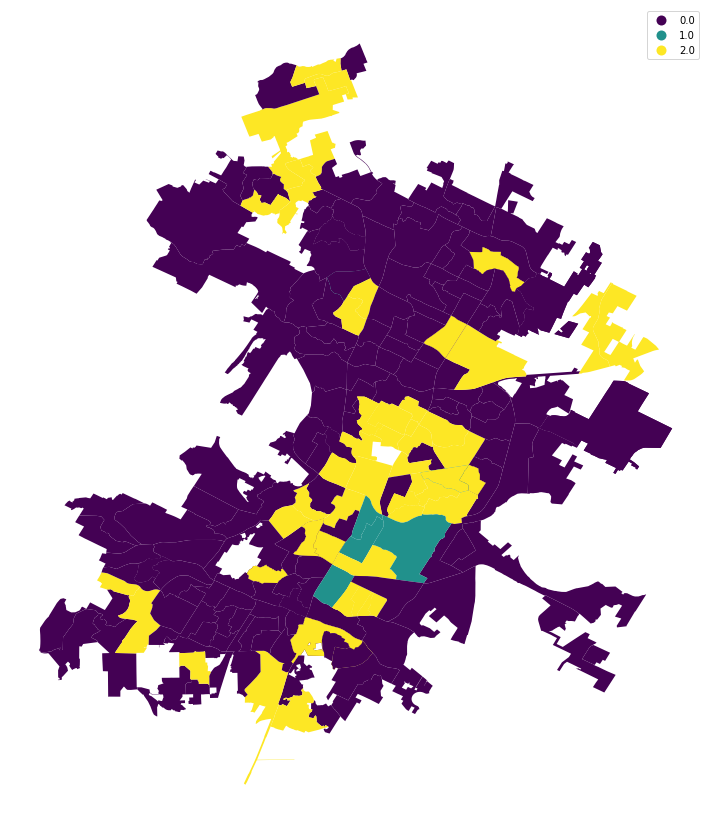

In [570]:
ax = loads_by_route_geo.plot(column = 'CLUSTER_LABEL', cmap='viridis', legend=True, figsize=(15, 15),  categorical=True)
ax.set_axis_off()

[Text(0.5, 0, '# Loads'), Text(0, 0.5, 'Total Weight')]

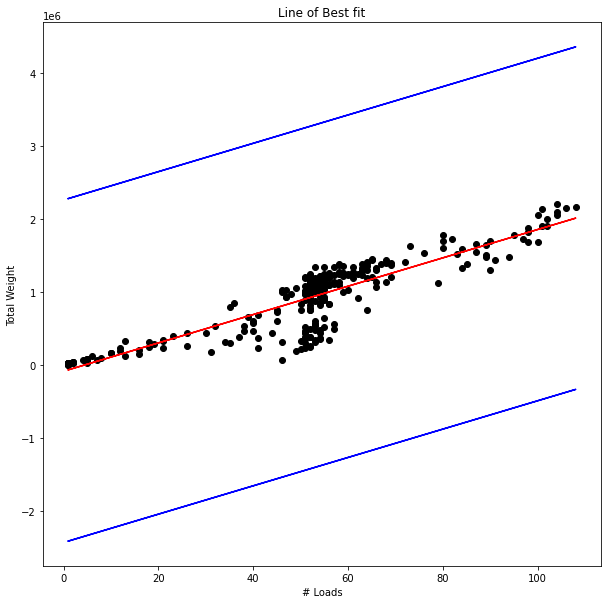

In [571]:

regr = LinearRegression()
regr.fit(loads_by_route[['Total_Loads']], loads_by_route[['Total_Weight']])
weight_predicted = regr.predict(loads_by_route[['Total_Loads']])
loads_by_route[['Residuals']] = abs(loads_by_route[['Total_Weight']] - weight_predicted)

fig, axs = plt.subplots(1, figsize=(10,10), sharex=True)
# individual chart chart
axs.scatter(loads_by_route[['Total_Loads']],loads_by_route[['Total_Weight']], color='black')
axs.plot(loads_by_route[['Total_Loads']],weight_predicted, color='red')
axs.plot(loads_by_route[['Total_Loads']],lower, color='blue')
axs.plot(loads_by_route[['Total_Loads']],upper, color='blue')


axs.set_title('Line of Best fit')
axs.set(xlabel='# Loads', ylabel='Total Weight')



/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


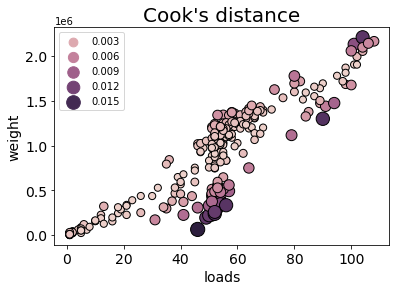

In [382]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import OLSInfluence

# fit the regression model using statsmodels library 
f = 'Total_Weight ~ Total_Loads'
model = ols(formula=f, data=loads_by_route).fit()

# calculate the cooks_distance - the OLSInfluence object contains multiple influence measurements
cook_distance = OLSInfluence(model).cooks_distance
(distance, p_value) = cook_distance

loads_by_route['CooksDistance'] = distance
# scatter plot - x axis (independent variable height), y-axis (dependent variable weight), size and color of the marks according to its cook's distance
sns.scatterplot(loads_by_route.Total_Loads, loads_by_route.Total_Weight, hue=distance, size=distance, sizes=(50, 200), edgecolor='black', linewidth=1)

# ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# labels and title
plt.xlabel('loads', fontsize=14)
plt.ylabel('weight', fontsize=14)
plt.title('Cook\'s distance', fontsize=20);

threshold: 0.013
Outliers:7


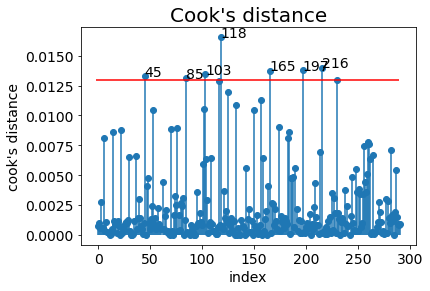

In [383]:

threshold = math.floor(4/len(loads_by_route)*1000)/1000
print(f'threshold: {threshold}')
# stem plot - the x-axis represents the index of the observation and the y-axis its Cook's distance
plt.stem(distance, basefmt=" ")

# horizontal line showing the threshold value
plt.hlines(threshold,-2,290,'r')

# the observations with Cook's distances higher than the threshold value are labeled in the plot
influencial_data = distance[distance >= threshold]
print(f'Outliers:{len(influencial_data)}')
for index, value in influencial_data.items():
    plt.text(index, value, str(index), fontsize=14)

# ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# labels and title
plt.xlabel('index', fontsize=14)
plt.ylabel('cook\'s distance', fontsize=14)
plt.title('Cook\'s distance', fontsize=20);


<AxesSubplot:xlabel='Route Number', ylabel='Weight_By_Load'>

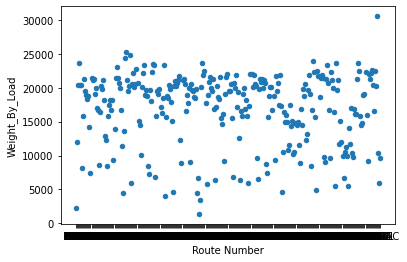

In [392]:
loads_by_route_nooutliers = loads_by_route[loads_by_route['CooksDistance'] < 0.013]
loads_by_route.plot(x ='Route Number', y='Weight_By_Load', kind = 'scatter')

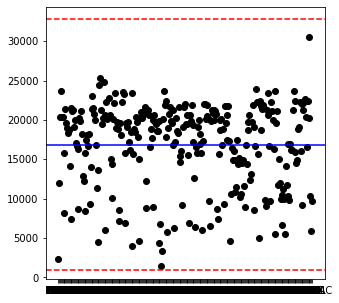

In [395]:
fig, axs = plt.subplots(1, figsize=(5,5), sharex=True)
# individual chart chart
axs.scatter(loads_by_route['Route Number'],loads_by_route['Weight_By_Load'], color='black')
axs.axhline(statistics.mean(loads_by_route['Weight_By_Load']), color='blue')
axs.axhline(statistics.mean(loads_by_route['Weight_By_Load'])+3*statistics.stdev(loads_by_route['Weight_By_Load']), color = 'red', linestyle = 'dashed')
axs.axhline(statistics.mean(loads_by_route['Weight_By_Load'])-3*statistics.stdev(loads_by_route['Weight_By_Load']), color = 'red', linestyle = 'dashed')

A few routes have many loads but very low total weight.
We can remove the max outlier to see better

<AxesSubplot:xlabel='Route Number', ylabel='Weight_By_Load'>

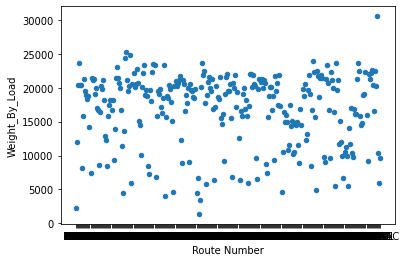

In [379]:
loads_by_route_no_outlier = loads_by_route[loads_by_route["Total_Weight"] != loads_by_route["Total_Weight"].max()]
loads_by_route_no_outlier.plot(x ='Route Number', y='Weight_By_Load', kind = 'scatter')


In [140]:
loads_by_route_no_outlier['Weight_Loads_Ratio'] = loads_by_route_no_outlier['Total_Weight'] / loads_by_route_no_outlier['Total_Loads']
loads_by_route_no_outlier = loads_by_route_no_outlier.sort_values(by='Weight_Loads_Ratio')
loads_by_route_no_outlier


/var/folders/pq/vs_mpvbj7677j7s11l_m3r380000gn/T/ipykernel_89187/143304809.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loads_by_route_no_outlier['Weight_Loads_Ratio'] = loads_by_route_no_outlier['Total_Weight'] / loads_by_route_no_outlier['Total_Loads']


,Route Number,Total_Weight,Total_Loads,Weight_Loads_Ratio
1332,SR10,140.0,1,140.000000
236,NR51,180.0,1,180.000000
1108,RPBAGS,7767.0,40,194.175000
287,OFNONGS,280.0,1,280.000000
107,DA02,779890.0,2623,297.327488
...,...,...,...,...
732,PH13,11633048.0,464,25071.224138
1385,TNONJM00,25540.0,1,25540.000000
182,MNONCG,30380.0,1,30380.000000
150,E13-R,31857.0,1,31857.000000


<AxesSubplot:xlabel='Route Number'>

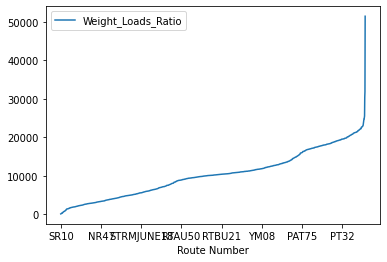

In [141]:
loads_by_route_no_outlier.plot(x ='Route Number', y='Weight_Loads_Ratio', kind = 'line')

[Text(0.5, 0, 'Route Number'), Text(0, 0.5, 'Value')]

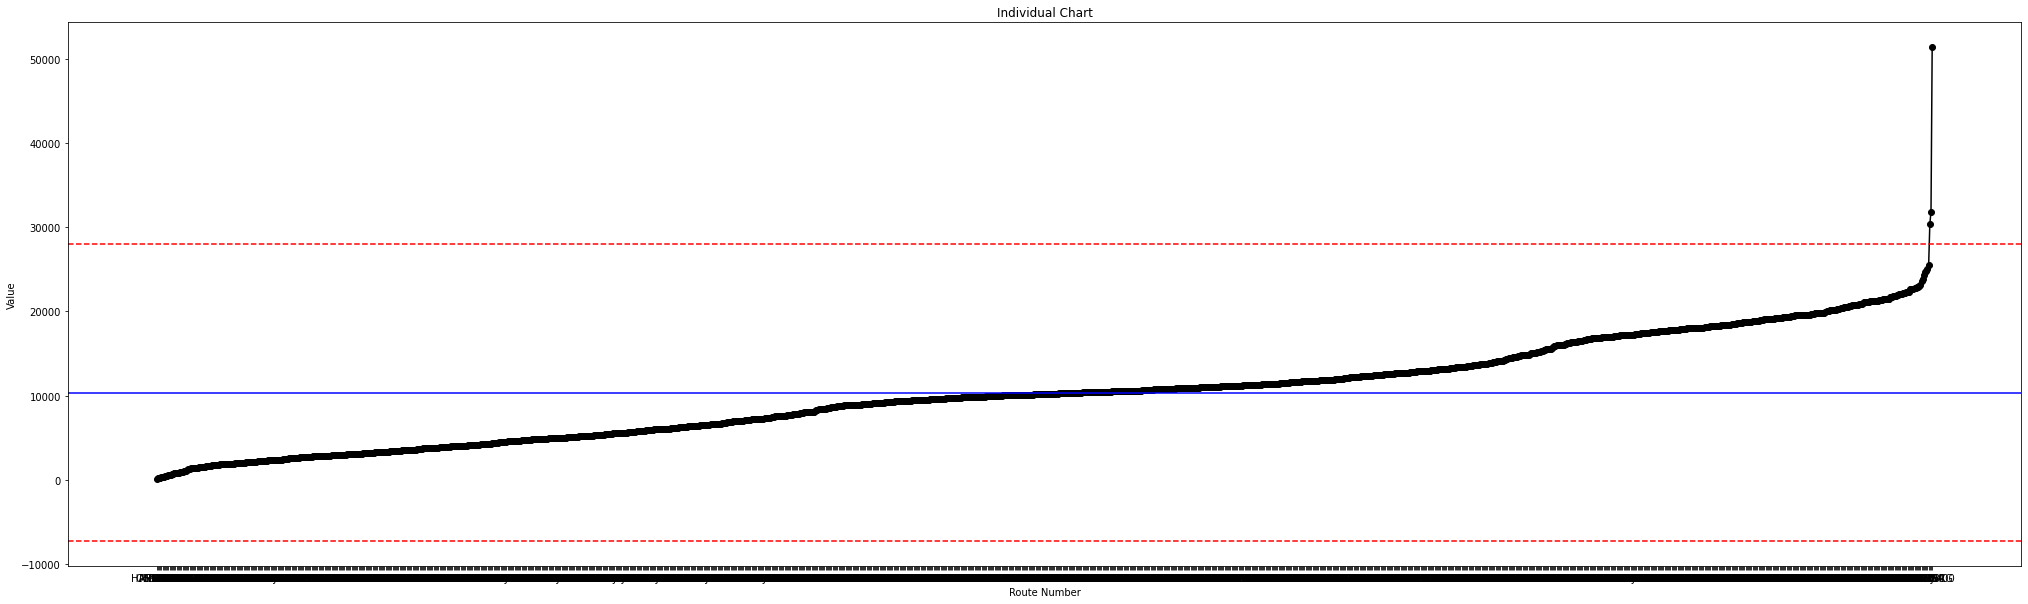

In [147]:
fig, axs = plt.subplots(1, figsize=(35,10), sharex=True)
# individual chart chart
axs.plot(loads_by_route_no_outlier['Route Number'],loads_by_route_no_outlier['Weight_Loads_Ratio'], linestyle='-', marker='o', color='black')
axs.axhline(statistics.mean(loads_by_route_no_outlier['Weight_Loads_Ratio']), color='blue')
axs.axhline(statistics.mean(loads_by_route_no_outlier['Weight_Loads_Ratio'])+3*statistics.stdev(loads_by_route_no_outlier['Weight_Loads_Ratio']), color = 'red', linestyle = 'dashed')
axs.axhline(statistics.mean(loads_by_route_no_outlier['Weight_Loads_Ratio'])-3*statistics.stdev(loads_by_route_no_outlier['Weight_Loads_Ratio']), color = 'red', linestyle = 'dashed')
axs.set_title('Individual Chart')
axs.set(xlabel='Route Number', ylabel='Value')